# A simple model for halogen bonds

What follows is a walkthrough of a simplified example of the analysis carried out to fit a statistical model to the interaction energies of halogen-bonded systems. It can be used both as an explanation of some of the analysis performed in the associated paper, and as a template for applying the same techniques to other types of interaction, such as chalcogen bonds.

These models take some functional form

\begin{equation}
E_{ij} = f(X_i, B_j)
\end{equation}

where $E_{ij}$ is the interaction energy between the halogen-containing donor $i$ and the Lewis base $j$, each with a single parameter $X_i$ and $B_j$, respectively. In this procedure, it is important to split the data into fitting and validation sets, so that the quality of the fit can be assessed later. We will start by looking at the fitting data. 

## Examining the data

In [1]:
import pandas as pd

In [2]:
with open("./datasets/fitdata.csv") as f:
    fit_data = pd.read_csv(f)

Let's take a look at the form of this data:

In [3]:
print(fit_data.head(n=5))

    AX     B      ECBS       R
0  Br2   H2O -3.992106  2.7918
1  Br2  CH2O -4.441659  2.7498
2  Br2   HCN -3.656430  2.8888
3  Br2  CH2S -6.419127  2.9106
4  Br2   H3N -7.810330  2.5978


The first two columns, X and B, give the labels for the donors and Lewis bases, respectively. We then have the CCSD(T)-F12b [1] interaction energies (kcal/mol) extrapolated to the complete basis set limit in ECBS. This is followed finally by the intermolecular separation, $R_{ij}$, in angstroms from the optimized geometry at the CCSD(T)-F12b/VTZ-F12 [2] level; this is the distance between the halogen atom on the donor and the interacting atom on the base. 

The CBS limit energies were determined using the approach of Hill *et al.* [3], taking the triple- and quadruple-zeta correlation energies and extrapolating as follows:

\begin{equation}
E_{\text{CBS}} \approx (E_{\text{QZ}} - E_{\text{TZ}})F + E_{\text{TZ}}
\end{equation}

where $F=1.363388$ for the CCSD part of the correlation energy, and $1.769474$ for the (T) part.

## Fitting a model

We now need to define a model to fit to; we start with a linear model:

\begin{equation}
f(X_i, B_j) = X_i + B_j + c
\end{equation}

where $c$ is a constant to be determined. 

In [4]:
import numpy as np

In [5]:
# Make a matrix Eij = Xi + Bj + c (params[0])
# assumes X, B are numpy arrays
def f_linear(X, B, params):
    E = [[b for b in B] + x + params[0] for x in X]
    return np.matrix(E)

The above can be replaced by any functional form with the same argument list, returning a numpy matrix with shape $(nx, nb)$. 

Then we choose a least squares loss function

\begin{equation}
\epsilon(f, X, B) = \sum_{i, j} (E_{ij}^{\text{CBS}} - f(X_i, B_j))^2
\end{equation}

For simplicity, we do not include regularisation here, although in practise it is often better to do so.

In [6]:
# We concatenate X and B and into a single array params,
# followed by any extra parameters. nx and nb are the number
# of donors and Lewis bases, respectively.
def loss(params, f, E, nx, nb):
    X = np.array(params[:nx])
    B = np.array(params[nx:nx+nb])
    npoints = nx * nb
    
    # Difference between predicted and actual 
    delta = (E - f(X, B, params[nx+nb:]))
    return np.sum(np.square(delta))/npoints

Before we can optimize the parameters by minimizing this loss, we need to reshape the interaction energies into a matrix, with the donors defining the rows, and the Lewis bases the columns. 

In [7]:
ECBS = fit_data.pivot(index="AX", columns="B", values="ECBS").as_matrix()
print(ECBS)

[[ -4.441659  -6.419127  -3.992106  -4.03399   -7.81033   -3.65643 ]
 [ -6.181753  -8.712724  -5.666235  -5.675712 -11.052197  -5.350233]
 [ -5.349523  -7.760402  -4.88784   -4.915292  -9.796414  -4.560241]
 [ -7.186337 -10.144137  -6.643573  -6.656585 -12.942191  -6.409411]
 [ -8.672808 -14.343649  -8.054001  -9.031993 -16.674148  -7.795704]
 [ -5.850389  -9.781415  -5.364156  -5.368393 -11.651009  -4.818638]
 [-10.12494  -14.712791  -9.448778  -9.958498 -17.96776   -9.552144]
 [ -2.109841  -2.186941  -1.686314  -1.38504   -2.262964  -1.435816]
 [ -2.901197  -2.978537  -2.543681  -1.995972  -3.595643  -2.246903]
 [ -4.758603  -6.463099  -4.342814  -4.203034  -8.177679  -4.023849]]


Then we choose a starting guess for the parameters, and minimize the loss function.

In [8]:
X = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
B = [-2, -2, -2, -2, -2, -2]
c = [0.0]
params = X + B + c

In [9]:
from scipy.optimize import minimize
result = minimize(loss, params, args=(f_linear, ECBS, len(X), len(B)))

We can then inspect the resulting parameters, the value of the loss, and construct the predicted energy matrix:

The loss value here is just the averaged sum of square differences, whereas really we would like to know the root-mean-square deviation. The former is chosen as it is an easier loss function to use than the RMSD, and it can easily be shown that both must give the same results, and the RMSD can be calculated from it:

In [10]:
linear_sse = result.fun * ECBS.size
linear_rmsd = np.sqrt(result.fun)
print("RMSD for model:", linear_rmsd, "kcal/mol")

RMSD for model: 1.01412371373 kcal/mol


So we see that the linear model is not a particularly good one, essentially just revealing the relative strengths of the donors and acceptors, as shown from the parameters. This does give some interesting information, though, particularly the fact that the parameters for all the donors are positive, except for ClBr, ClI, and HI.

Note that as with most optimizations, the choice of starting guess can have a considerable effect on the results obtained, and so ideally multiple starting guesses should be tried. Additionally, the choice of algorithm (BFGS is the default here) can make a large difference. In the analysis in the paper, we have made use of the fact that the 1st and 2nd derivatives of the loss function are easily calculable, allowing us to use algorithms that make use of the Hessian, and to use a special type of line-search. All of these help to ensure that we are as close as possible to an optimal solution.

## Principal components analysis

For the product models, $Pn$, described in the paper, we can use an even simpler approach. These have the form

\begin{equation}
E_{ij}^{Pn} = k\frac{X_i B_j}{R_{ij}^n}
\end{equation}

where $k$ is a constant prefactor.

By rewriting this as

\begin{equation}
E_{ij}^{Pn} R_{ij}^n = k X_iB_j
\end{equation}

the parameters can be understood as arising from the principal component of a principal components analysis [4]. In this special case, this can be enacted by first forming the matrix of values $M_{ij}^n = E_{ij}^{Pn} R_{ij}^n$:

In [11]:
n = 1
fit_data['Rnij'] = fit_data['R']**n
fit_data['Mnij'] = fit_data['ECBS'] * fit_data['Rnij']
Mn = fit_data.pivot(index="AX", columns="B", values="Mnij").as_matrix()

We then perform a singular value decomposition on the matrix $M^n$, to find left and right pseudo-eigenvectors, $u$ and $v$, along with a diagonal matrix $\Lambda$:

\begin{equation}
M^n_{ij} = \sum_{kl} U_{ik}\Lambda_{kl}V_{lj}
\end{equation}

but as $\Lambda$ is diagonal, this reduces to

\begin{equation}
M^n_{ij} = \sum_{k} U_{ik} \lambda_k V_{kj}
\end{equation}

The $\{\lambda_k\}$ are called the singular values; these are the square root of the eigenvalues (i.e. principal components) of the matrix. If only the first of these is significant, we can neglect all terms not involving $\lambda_1$, leaving

\begin{equation}
M^n_{ij} \approx U_{i1} \lambda_1 V_{1j}
\end{equation}

We then clearly have a correspondence to the $Pn$ model where $X_i = U_{i1}$, $B_j = V_{1j}$, and $k = \lambda_1$. 

Let's look at the decomposition and singular values of $M^n$ more closely:

In [12]:
u, lam, v = np.linalg.svd(Mn)
print(lam)

[  1.57815317e+02   4.37224422e+00   2.30365897e+00   1.81594878e+00
   4.23030261e-01   1.32747165e-01]


The first component is orders of magnitude greater than any of the others. We can determine the percentage variance, $\sigma^2$, explained by each component $\lambda_i$ as follows:

\begin{equation}
\sigma^2(\lambda_i) = \frac{\lambda_i^2}{\sum_{j} \lambda_j^2}
\end{equation}

For the first two components above, this gives:

In [15]:
s2_1 = lam[0]**2 / np.sum(lam**2)
s2_2 = lam[1]**2 / np.sum(lam**2)
print("% variance explained by 1st component:", s2_1 * 100)
print("% variance explained by 2nd component:", s2_2 * 100)

% variance explained by 1st component: 99.8880321351
% variance explained by 2nd component: 0.0766697376098


We can then extract the parameters and reconstruct the predicted, distance-weighted energies by a matrix-matrix multiplication. 

In [16]:
X = u[:, 0]
B = v[0, :]
print("k:", lam[0])
print("Donor parameters:", X)
print("Acceptor parameters:", B)

lam1 = np.zeros(shape=(len(X), len(B)))
lam1[0, 0] = lam[0]
Mnpred = np.dot(np.dot(u, lam1), v)

k: 157.815317279
Donor parameters: [-0.22875345 -0.32593938 -0.27338509 -0.37403785 -0.43610008 -0.29178583
 -0.50787669 -0.09511245 -0.14136147 -0.25397094]
Acceptor parameters: [ 0.3295379   0.51412497  0.30764001  0.35252088  0.56392943  0.30025079]


The predicted energies are then recovered by dividing through by the distance powers from the original model.

In [17]:
Rnij = fit_data.pivot(index="AX", columns="B", values="Rnij").as_matrix()
Enpred = Mnpred / Rnij
print(Enpred)

[[ -4.32634425  -6.37680277  -3.97809659  -4.08692803  -7.8367475
   -3.75217852]
 [ -6.08211165  -8.87855931  -5.5976146   -5.73540254 -10.95947161
   -5.31483124]
 [ -5.30392455  -7.81234469  -4.87796022  -5.00371292  -9.67525798
   -4.61937974]
 [ -7.12954864 -10.39251856  -6.5579618   -6.70887588 -12.81101249
   -6.27512904]
 [ -9.17211017 -13.78301777  -8.4360476   -8.80384658 -16.66586595
   -8.15125319]
 [ -6.06767616  -9.30896793  -5.56938639  -5.76598503 -11.30074253
   -5.24488084]
 [-10.21530796 -14.92970802  -9.39765549  -9.66438717 -18.14506217
   -9.18418393]
 [ -1.59187413  -2.16669561  -1.48146895  -1.44982043  -2.66932441
   -1.388467  ]
 [ -2.33016251  -3.18981468  -2.16393698  -2.11961028  -3.94750688
   -2.0249392 ]
 [ -4.55041872  -6.62670066  -4.20429857  -4.27885728  -8.19616925
   -3.96409617]]


## Assessing the fit

A simple assessment of the fitting can be found by calculating the errors and root-mean-square deviation.

In [18]:
errs = Enpred - ECBS
Pn_sse = np.sum(errs**2)
Pn_rmsd = np.sqrt(Pn_sse/errs.size)
print("RMSD for Pn model:", Pn_rmsd, "kcal/mol")

RMSD for Pn model: 0.240946854194 kcal/mol


This seems like a considerable improvement on the linear model from earlier. Even more useful is to look at the distribution of the errors; here we choose a violin plot. 

In [19]:
errs_ravel = np.ravel(errs)

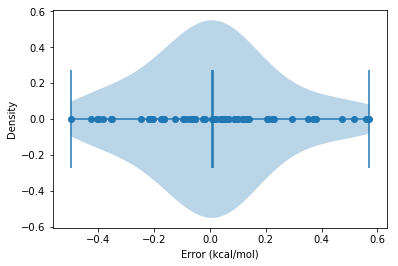

In [20]:
import matplotlib.pyplot as plt
plt.violinplot(errs_ravel, [0], points=200, vert=False, widths=1.1,
                      showmeans=True, showextrema=True, showmedians=True,
                      bw_method=0.5)
plt.scatter(errs_ravel, np.zeros_like(errs_ravel))
plt.xlabel("Error (kcal/mol)")
plt.ylabel("Density")
plt.show()

For some information about the *efficiency* of the model, we can compute the Akaike Information Criterion [5], which is defined in terms of the log-likelihood of the loss function. For least squares, this means we can consider:

\begin{equation}
\text{AIC} = 2p + N\ln \epsilon(Pn, X, B)
\end{equation}

where $p$ is the number of parameters and $N$ is the number of samples. This is only meaningful when comparing models - a smaller AIC indicates that there is a better balance between the loss and the number of parameters, i.e. greater efficiency. The AIC for the two models used so far are:

In [21]:
p = len(X) + len(B) + 1
N = ECBS.size

Pn_AIC = 2 * p + N * np.log(Pn_sse)
linear_AIC = 2 * p + N * np.log(linear_sse)

print("Pn AIC:", Pn_AIC)
print("Linear AIC:", linear_AIC)

Pn AIC: 108.879206714
Linear AIC: 281.343662138


The $Pn$ model thus appears to be more efficient than the linear model. 

## Finding new parameters

Considerably more validation needs to be carried out than the quick approach described above. At the beginning, we separated out a validation set of molecules - bigger than the fitting set in this case -  such that we could try and predict interaction energies not present in the fitting set. 

The principle of doing so is simple. We take a new molecule, and calculate its interaction energy with one of the existing molecules. The simple form of the $Pn$ models then allows us to determine the new parameter by dividing out the known quantities. 

For example, suppose we wish to determine a parameter for some halogen donor $k$, and have calculated its interaction with water, giving us an interaction energy $E_{k1}$ and separation $R_{k1}$. Then, as we know the water parameter, we find that

\begin{equation}
X_k = \frac{E_{k1} R_{k1}}{k B_1}
\end{equation}

In [22]:
with open("./datasets/bigdft.csv") as f:
    big_data = pd.read_csv(f)
    
print(big_data.head(5))

    AX    B  Eint      R
0  Br2  Gly -5.08  2.752
1   I2  Gly -5.78  2.869
2  BrI  Gly -7.47  2.771
3  Br2  Val -5.81  2.751
4   I2  Val -6.62  2.879


The most interesting case is to take two new molecules, neither in the fitting or validation sets, calculated at a different level of theory, and see if the model still holds up. We do this here with some of the set of larger molecules used in the paper: glycine, valine, and leucine as the new Lewis bases; hexafluorobenzene with one fluorine substituted for Cl, Br, or I for the new donors. These were optimized at the M06-2X/aVTZ level of theory [6, 7], a considerably cheaper calculation than the benchmark CCSD(T)-F12b calculations used earlier.

We will choose for simplicity's sake to calculate the parameters relative to BrI for the bases and H2O for the donors; ideally, we would try and determine which system is the best reference. For valine and C6F5Br in the $Pn$ model, this gives:

In [23]:
big_data['ERn'] = big_data['Eint'] * big_data['R'] ** n / lam[0]
Bvaline = big_data['ERn'][5] / X[2]
Xc6f5br = big_data['ERn'][12] / B[0]

print("Valine parameter:", Bvaline)
print("C6F5Br parameter:", Xc6f5br)

Valine parameter: 0.536613425953
C6F5Br parameter: -0.167461032687


The predicted interaction energy for the complex between valine and C6F5Br is thus

In [24]:
E_valine_c6f5br = lam[0] * Bvaline * Xc6f5br / big_data['R'][22]**n
print("Predicted energy:", E_valine_c6f5br, "kcal/mol")
print("Actual energy:", big_data['Eint'][22], "kcal/mol")

Predicted energy: -4.88851242624 kcal/mol
Actual energy: -4.61 kcal/mol


This is within 0.3 kcal/mol despite this being an extrapolation to completely new molecules using a lower level of theory. Of course, unless $n = 0$, we need to know the separation, meaning that a calculation cannot be avoided. However, estimates of this separation can be readily obtained by much cheaper methods, and the resulting interaction is insensitive. For example, using the HF/VDZ [8] separation of $\sim 3.0$ angstrom, the predicted energy is

In [25]:
lam[0] * Bvaline * Xc6f5br / 3.0**n

-4.7271915161707323

which is within 0.2 kcal/mol of the original prediction. In fact, in this case it serendipitously improves the prediction, but more generally it demonstrates that the predictions are not especially sensitive to small errors in the separation.

### References

1. S. Ten-no, Chem. Phys. Lett., 2004, 398, 56–61; C. Hättig, D. P. Tew and A. Köhn, J. Chem. Phys., 2010, 132, 231102
2. K. A. Peterson, T. B. Adler and H.-J. Werner, J. Chem. Phys., 2008, 128, 084102; J. G. Hill and K. A. Peterson, J. Chem. Phys., 2014, 141, 094106
3. J. G. Hill, K. A. Peterson, G. Knizia and H.-J. Werner, J. Chem. Phys., 2009, 131, 194105
4. Karl Pearson F.R.S., Philosophical Magazine, Vol. 2, Iss. 11, 1901
5. H. Akaike, IEEE Transactions on Automatic Control, 19 (6), 1974 
6. Y. Zhao and D. G. Truhlar, Theor. Chem. Acc., 2008, 120, 215–241
7. T. H. Dunning, J. Chem. Phys., 1989, 90, 1007–1023; R. A. Kendall, T. H. Dunning and R. J. Harrison, J. Chem. Phys., 1992, 96, 6796–6806; T. H. Dunning, K. A. Peterson and A. K. Wilson, J. Chem. Phys., 2001, 114, 9244–9253
8. T. H. Dunning, Jr., J. Chem. Phys. 1989, 90, 1007-1023;  A.K. Wilson, D.E. Woon, K.A. Peterson, and T.H. Dunning, Jr., J. Chem. Phys. 1999, 110, 7667-7676